In [1]:
import $ivy.`org.apache.spark::spark-sql:2.4.3`


import org.apache.spark.sql._
import org.apache.spark.sql.functions._


//Reducir numero logs
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)


//Circe para trabajar con JSON
import $ivy.`com.softwaremill.sttp.client::async-http-client-backend-monix:2.0.0-RC2`
import sttp.client.quick.{quickRequest, UriContext, backend}
import sttp.client.asynchttpclient.monix._


//Sttp para realizar request
import $ivy.`com.softwaremill.sttp.client::async-http-client-backend-monix:2.0.0-RC2`
import sttp.client.quick.{quickRequest, UriContext, backend}
import sttp.client.asynchttpclient.monix._
import sttp.client.basicRequest

//For adding extra dependenies
import $ivy.`org.typelevel::cats-core:1.6.0`

//Plotly
import $ivy.`org.plotly-scala::plotly-almond:0.7.1`
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._

import $ivy.$                                  



import org.apache.spark.sql._

import org.apache.spark.sql.functions._


//Reducir numero logs

import org.apache.log4j.{Level, Logger}

import $ivy.$                                                                        

import sttp.client.quick.{quickRequest, UriContext, backend}

import sttp.client.asynchttpclient.monix._


//Sttp para realizar request

import $ivy.$                                                                        

import sttp.client.quick.{quickRequest, UriContext, backend}

import sttp.client.asynchttpclient.monix._

import sttp.client.basicRequest

//For adding extra dependenies

import $ivy.$                               

//Plotly

import $ivy.$                                      

import plotly._, plotly.element._, plotly.layout._, plotly.Almond._

In [2]:
//Iniciamos session de Spark
val spark = {
  NotebookSparkSession.builder()
     .master("local[*]")
    .config("spark.executor.instances", "4") // Número de ejecutores
    .config("spark.executor.memory", "4g") // Memoria por ejecutor
    .config("spark.executor.cores", "2") // Núcleos por ejecutor
    .config("spark.driver.memory", "4g") // Memoria del driver
    .config("spark.sql.shuffle.partitions", "8") // Número de particiones para operaciones de shuffle
    .getOrCreate()
}
import spark.implicits._

//Crear URL
def createUri(category: String, widget: String, start_date: String, end_date: String, time_trunc: String, lang: String, 
              geo_trunc: String = "", geo_limit: String = "", geo_ids: String = ""): String = {
  val baseUrl = s"https://apidatos.ree.es/$lang/datos/$category/$widget"
  
  // Crear un mapa con los parámetros obligatorios y opcionales
  val params = Map(
    "start_date" -> start_date,
    "end_date" -> end_date,
    "time_trunc" -> time_trunc,
    "geo_trunc" -> geo_trunc,
    "geo_limit" -> geo_limit,
    "geo_ids" -> geo_ids
  ).filter { case (_, v) => v.nonEmpty } // Filtrar los parámetros que no están vacíos

  //Especifico el orden concreto de los paramtros ya que, Scala map no te garantiza el orden
  val orderedKeys = Seq("start_date", "end_date", "time_trunc", "geo_trunc", "geo_limit", "geo_ids")

  // Unir los parámetros en una cadena
  val queryString = orderedKeys.flatMap(key => params.get(key).map(value => s"$key=$value")).mkString("&")
  
  s"$baseUrl?$queryString"
}

//Lanzar llamada y obtener guardar datos
def getDataApi(apiUrl: String): Either[String, String] = {
 
    val newRequest = basicRequest.get(uri"$apiUrl")
    val response = newRequest.send()
  
  response.body match {
    case Right(body) => 
      Right(body)
      
    case Left(error) => 
      Left(s"Error fetching data: $error")
  }
}

// Transformar response a DataFrame
def responseToDF(response: Either[String, String]): DataFrame = {
    response match {
    case Right(body) => 
        val rdd = spark.sparkContext.parallelize(Seq(body))
        spark.read.json(rdd)
    case Left(error) => 
        println(error)
        spark.emptyDataFrame
    }
}


Loading spark-stubs
Getting spark JARs
Creating SparkSession


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties


Spark UI

spark: SparkSession = org.apache.spark.sql.SparkSession@6b3ba862
import spark.implicits._

//Crear URL

defined function createUri
defined function getDataApi
defined function responseToDF

In [3]:
def transformDataFrame(df: DataFrame): DataFrame = {
    // Definir los tipos de energía de bajas emisiones
    val bajasEmisiones = Seq(
    "Solar fotovoltaica", 
    "Solar térmica", 
    "Nuclear", 
    "Hidroeólica", 
    "Eólica", 
    "Generación renovable", 
    "Otras renovables",
    "Hidráulica", 
    "Residuos renovables"
  )
    //Crear modelo desanidado
   df.withColumn("FamilyGroup", explode($"included"))
    .withColumn("TypeGroup", explode($"FamilyGroup.attributes.content"))
    .withColumn("Values", explode($"TypeGroup.attributes.values"))
    .select(
      $"FamilyGroup.type".as("Familia"),
      $"TypeGroup.type".as("Tipo"),
      $"Values.datetime".as("FechaCompleta"), 
      $"Values.percentage".as("Porcentaje"),
      $"Values.value".as("Valor")
    )
    .withColumn("FechaCompleta", $"FechaCompleta".cast("timestamp"))
    .withColumn("Dia", to_date($"FechaCompleta"))
    .withColumn("Hora", date_format($"FechaCompleta", "HH:mm:ss"))
    .withColumn("BajasEmisiones", $"Tipo".isin(bajasEmisiones: _*))
}

defined function transformDataFrame

In [4]:
val category = "balance"
val widget = "balance-electrico"
val time_trunc = "day"
val lang = "es"
val geo_trunc = "electric_system"
val geo_limit = "ccaa"
val geo_ids = "11"

val rango = (2024 to 2024).map( year => (year + "-01-01T00:00", year + "-12-31T23:59"))
val urisRango = rango.map {
    case (inicio, fin) => createUri(category, widget, inicio, fin, time_trunc,lang,geo_trunc, geo_limit, geo_ids)
    }

category: String = "balance"
widget: String = "balance-electrico"
time_trunc: String = "day"
lang: String = "es"
geo_trunc: String = "electric_system"
geo_limit: String = "ccaa"
geo_ids: String = "11"
rango: collection.immutable.IndexedSeq[(String, String)] = Vector(
  ("2024-01-01T00:00", "2024-12-31T23:59")
)
urisRango: collection.immutable.IndexedSeq[String] = Vector(
  "https://apidatos.ree.es/es/datos/balance/balance-electrico?start_date=2024-01-01T00:00&end_date=2024-12-31T23:59&time_trunc=day&geo_trunc=electric_system&geo_limit=ccaa&geo_ids=11"
)

In [5]:
val listBalanceJson = urisRango.map(getDataApi(_))

listBalanceJson: collection.immutable.IndexedSeq[Either[String, String]] = Vector(
  Right(
    "{\"data\":{\"type\":\"Balance de energ\\u00eda el\\u00e9ctrica\",\"id\":\"bal1\",\"attributes\":{\"title\":\"Balance de energ\\u00eda el\\u00e9ctrica\",\"last-update\":\"2024-09-09T13:37:13.000+02:00\",\"description\":\"Balance el\\u00e9ctrico: asignaci\\u00f3n de unidades de producci\\u00f3n seg\\u00fan combustible principal. La producci\\u00f3n neta de las instalaciones no renovables e hidr\\u00e1ulicas UGH tiene descontados los consumos propios de las instalaciones. En dichos tipos de producci\\u00f3n una generaci\\u00f3n negativa indica que la electricidad horaria consumida para los usos de las plantas excede la producci\\u00f3n horaria de las instalaciones.\"},\"meta\":{\"cache-control\":{\"cache\":\"HIT\",\"expireAt\":\"2024-10-25T10:07:22\"}}},\"included\":[{\"type\":\"Renovable\",\"id\":\"Renovable\",\"attributes\":{\"title\":\"Renovable\",\"last-update\":\"2024-05-21T16:53:06.000+0

In [6]:
val listModelsBalance = listBalanceJson.map{
    json => transformDataFrame(responseToDF(json))
}
val modelBalanceAsturias = listModelsBalance.reduce(_ union _)

json at cmd1.sc:57

16 / 16

listModelsBalance: collection.immutable.IndexedSeq[DataFrame] = Vector(
  [Familia: string, Tipo: string ... 6 more fields]
)
modelBalanceAsturias: DataFrame = [Familia: string, Tipo: string ... 6 more fields]

In [7]:
modelBalanceAsturias.show()

show at cmd6.sc:1

1 / 1

show at cmd6.sc:1

4 / 4

show at cmd6.sc:1

11 / 11

+---------+------------------+-------------------+--------------------+----------+----------+--------+--------------+
|  Familia|              Tipo|      FechaCompleta|          Porcentaje|     Valor|       Dia|    Hora|BajasEmisiones|
+---------+------------------+-------------------+--------------------+----------+----------+--------+--------------+
|Renovable|        Hidráulica|2023-12-31 23:00:00| 0.47926434045300637|163548.995|2023-12-31|23:00:00|          true|
|Renovable|        Hidráulica|2024-01-31 23:00:00| 0.42068413541212324|119757.218|2024-01-31|23:00:00|          true|
|Renovable|        Hidráulica|2024-02-29 23:00:00|  0.6810408965758138|287692.014|2024-02-29|23:00:00|          true|
|Renovable|        Hidráulica|2024-03-31 22:00:00|  0.5554509002091387|140873.339|2024-03-31|22:00:00|          true|
|Renovable|        Hidráulica|2024-04-30 22:00:00|   0.512909768714395|123607.549|2024-04-30|22:00:00|          true|
|Renovable|            Eólica|2023-12-31 23:00:00|  0.46

In [8]:
def AnalisisEnergiasAnual(listaEnergias: Seq[String], dataFrameBalance: DataFrame): Unit = {
  // Agrupar y calcular la media para datos renovables
  def calcularMediaMensual(df: DataFrame, tipo: String): DataFrame = {
    df.filter(col("Tipo") === tipo) 
      .filter(date_format(col("FechaCompleta"), "yyyy") === "2024")
      .groupBy(date_format(col("FechaCompleta"), "MM").as("Mes"))
      .agg(sum("Valor").as("ValorPromedio"))
      .orderBy("Mes")
  }

  val valores = listaEnergias.map(tipoEnergia => calcularMediaMensual(dataFrameBalance, tipoEnergia))
  val fechas = valores.head.select("Mes").as[String].collect.toSeq
  val seqValores = valores.map(valor => valor.select("ValorPromedio").as[Double].collect.toSeq)

  val traces = listaEnergias.zip(seqValores).map { case (nombre, seqValor) =>
    Scatter(fechas, seqValor, name = nombre)
  }

  val data = traces
  plot(data)
}



defined function AnalisisEnergiasAnual

collect at cmd7.sc:12

16 / 16

collect at cmd7.sc:12

8 / 8

collect at cmd7.sc:12

8 / 8

collect at cmd7.sc:12

4 / 4

collect at cmd7.sc:13

16 / 16

collect at cmd7.sc:13

8 / 8

collect at cmd7.sc:13

8 / 8

collect at cmd7.sc:13

4 / 4

collect at cmd7.sc:13

16 / 16

collect at cmd7.sc:13

8 / 8

collect at cmd7.sc:13

8 / 8

collect at cmd7.sc:13

4 / 4

collect at cmd7.sc:13

16 / 16

collect at cmd7.sc:13

8 / 8

collect at cmd7.sc:13

8 / 8

collect at cmd7.sc:13

1 / 1

collect at cmd7.sc:13

16 / 16

collect at cmd7.sc:13

8 / 8

collect at cmd7.sc:13

8 / 8

collect at cmd7.sc:13

4 / 4

collect at cmd7.sc:13

16 / 16

collect at cmd7.sc:13

8 / 8

collect at cmd7.sc:13

8 / 8

collect at cmd7.sc:13

4 / 4

collect at cmd7.sc:13

16 / 16

collect at cmd7.sc:13

8 / 8

collect at cmd7.sc:13

8 / 8

collect at cmd7.sc:13

4 / 4

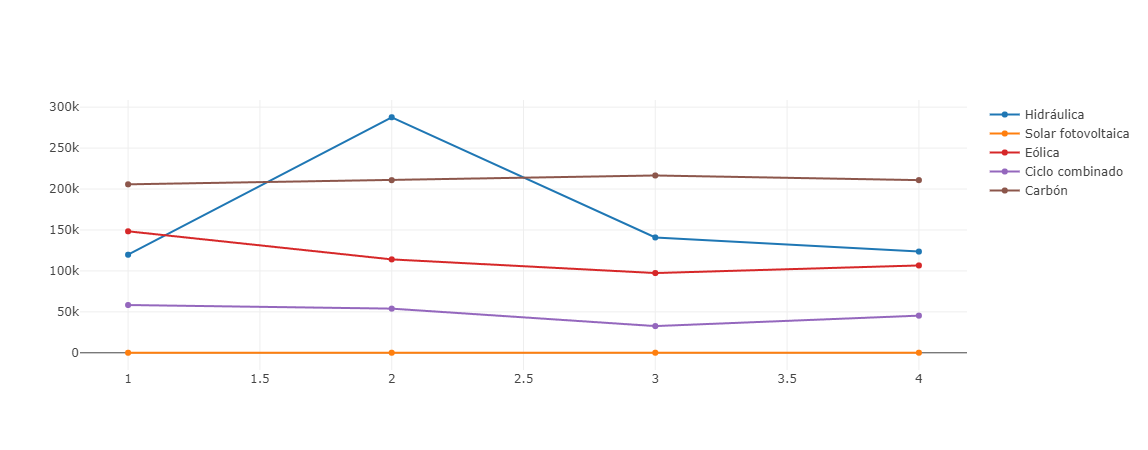

EnergiasParaAnalizar: Seq[String] = List(
  "Hidr\u00e1ulica",
  "Solar fotovoltaica",
  "Nuclear",
  "E\u00f3lica",
  "Ciclo combinado",
  "Carb\u00f3n"
)

In [9]:
val EnergiasParaAnalizar = Seq( "Hidráulica","Solar fotovoltaica","Nuclear", "Eólica", "Ciclo combinado", "Carbón")
AnalisisEnergiasAnual(EnergiasParaAnalizar, modelBalanceAsturias)

In [10]:
def crearDataFramePorRango(rango: Range, category: String, widget: String, time_trunc: String, lang: String, 
                           geo_trunc: String = "", geo_limit: String = "", geo_ids: String = ""): DataFrame = {
  // Crear el rango de fechas basado en los años proporcionados
  val rangoFechas = rango.map(year => (year + "-01-01T00:00", year + "-12-31T23:59"))

  // Crear las URIs para cada rango de fechas
  val uris = rangoFechas.map {
    case (inicio, fin) => createUri(category, widget, inicio, fin, time_trunc, lang, geo_trunc, geo_limit, geo_ids)

  }

  // Obtener los datos de la API para cada URI
  val listBalanceJson = uris.map(getDataApi(_))

  // Transformar los JSON en DataFrames
  val listModelsBalance = listBalanceJson.map { json =>
    transformDataFrame(responseToDF(json))
  }

  // Unir todos los DataFrames en uno solo
  val finalDataFrame = listModelsBalance.reduce(_ union _)

  finalDataFrame // Retorna el DataFrame
}

defined function crearDataFramePorRango

In [11]:
val category = "balance"
val widget = "balance-electrico"
val time_trunc = "day"
val lang = "es"
val geo_trunc = "electric_system"
val geo_limit = "ccaa"
val geo_ids = "11"
val rango = 2016 to 2024
val balanceAsturias16_24 = crearDataFramePorRango(rango, category, widget, time_trunc, lang, geo_trunc, geo_limit, geo_ids)

json at cmd1.sc:57

16 / 16

json at cmd1.sc:57

16 / 16

json at cmd1.sc:57

16 / 16

json at cmd1.sc:57

16 / 16

json at cmd1.sc:57

16 / 16

json at cmd1.sc:57

16 / 16

json at cmd1.sc:57

16 / 16

json at cmd1.sc:57

16 / 16

json at cmd1.sc:57

16 / 16

category: String = "balance"
widget: String = "balance-electrico"
time_trunc: String = "day"
lang: String = "es"
geo_trunc: String = "electric_system"
geo_limit: String = "ccaa"
geo_ids: String = "11"
rango: Range.Inclusive = Range.Inclusive(
  2016,
  2017,
  2018,
  2019,
  2020,
  2021,
  2022,
  2023,
  2024
)
balanceAsturias16_24: DataFrame = [Familia: string, Tipo: string ... 6 more fields]

head at cmd11.sc:11

144 / 144

head at cmd11.sc:11

8 / 8

head at cmd11.sc:12

144 / 144

head at cmd11.sc:12

8 / 8

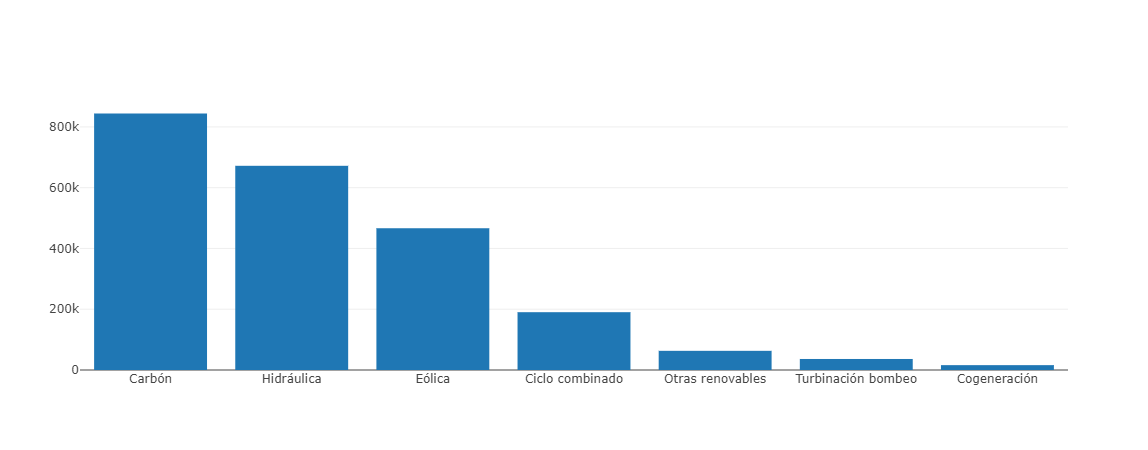

defined function top5anual
res11_1: String = "plot-5f55a2b1-ca2c-451f-9c3a-06554c49c891"

In [12]:
def top5anual (Año: Int) = {
val energiasOrdenadas= balanceAsturias16_24
    .filter(date_format(col("FechaCompleta"),"yyyy") === Año) //Año
    .filter(col("Familia") =!= "Demanda")
    .filter(!col("Tipo").isin("Generación renovable", "Generación no renovable"))
    .groupBy($"Tipo")
    //.groupBy(date_format(col("FechaCompleta"), "yyyy-MM").as("Mes"))
    .agg(sum("Valor").as[Double].as("ValorTotal"))
    .orderBy($"ValorTotal".desc)

val seqValores = energiasOrdenadas.select($"ValorTotal").as[Double].head(7).toSeq
val seqTipo = energiasOrdenadas.select($"Tipo").as[String].head(7).toSeq
val data = Seq(Bar(
    seqTipo,
    seqValores,
))

plot(data)
}
top5anual(2024)

collect at cmd12.sc:12

144 / 144

collect at cmd12.sc:12

8 / 8

collect at cmd12.sc:12

8 / 8

collect at cmd12.sc:12

8 / 8

collect at cmd12.sc:13

144 / 144

collect at cmd12.sc:13

8 / 8

collect at cmd12.sc:13

8 / 8

collect at cmd12.sc:13

8 / 8

collect at cmd12.sc:13

144 / 144

collect at cmd12.sc:13

8 / 8

collect at cmd12.sc:13

8 / 8

collect at cmd12.sc:13

8 / 8

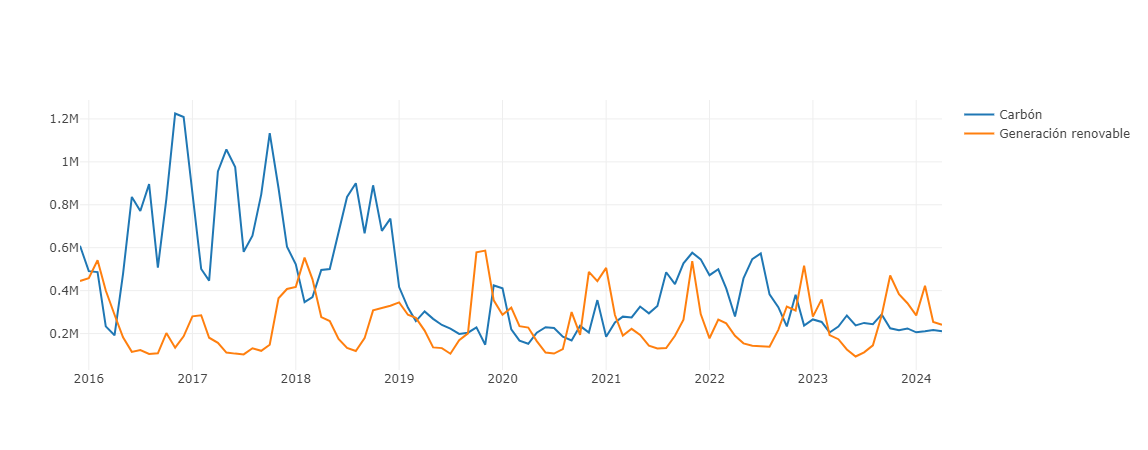

defined function AnalisisEnergiasMensual
EnergiasParaAnalizar: Seq[String] = List(
  "Carb\u00f3n",
  "Generaci\u00f3n renovable"
)

In [13]:
def AnalisisEnergiasMensual(listaEnergias: Seq[String], df: DataFrame, año: String): Unit = {
  val dataFrameBalance = df.filter(date_format(col("FechaCompleta"),"yyyy") === año) //Elegimos año
  // Agrupar y calcular la media para datos renovables
  def calcularMediaMensual(df1: DataFrame, tipo: String): DataFrame = {
    df1.filter(col("Tipo") === tipo)
      .groupBy(date_format(col("FechaCompleta"), "yyyy-MM").as("Mes"))
      .agg(avg("Valor").as("ValorPromedio"))
      .orderBy("Mes")
  }

  val valores = listaEnergias.map(tipoEnergia => calcularMediaMensual(df, tipoEnergia))
  val seqFechas = valores.head.select("Mes").as[String].collect.toSeq
  val seqValores = valores.map(valor => valor.select("ValorPromedio").as[Double].collect.toSeq)

  val traces = listaEnergias.zip(seqValores).map { case (nombre, seqValor) =>
    Scatter(seqFechas, seqValor, name = nombre)
  }

  val data = traces
  plot(data)
}

val EnergiasParaAnalizar = Seq("Carbón","Generación renovable")

AnalisisEnergiasMensual(EnergiasParaAnalizar, balanceAsturias16_24, "2024")

In [ ]:
balanceAsturias16_24.select("Tipo").distinct.collect


collect at cmd13.sc:1 
 (kill)

99 + 17 / 144

In [21]:
def imprimirPorcentajeEnergia(df: DataFrame, año: String): Unit = {
    val dfFiltrado = df.filter(date_format(col("FechaCompleta"), "yyyy") === año)  

// Calcular la suma de energías renovables en ese año
    val totalRenovables = dfFiltrado
    .filter(col("Tipo") === "Generación renovable")
    .agg(sum("Valor"))
    .as[Double]
    .first()
    
  // Calcular la suma de energías no renovables en ese año
    val totalNoRenovables = dfFiltrado
    .filter(col("Tipo") === "Generación no renovable")
    .agg(sum("Valor"))
    .as[Double]
    .first()
    
    val totalEnergia = dfFiltrado
    .filter(col("Tipo") === "Demanda en b.c.")
    .agg(sum("Valor"))
    .as[Double]
    .first()

    val totalConsumoBombeo = dfFiltrado
    .filter(col("Tipo") === "Consumos en bombeo")
    .agg(sum("Valor"))
    .as[Double]
    .first()

    val totalSaldoIntercambios = dfFiltrado
    .filter(col("Tipo") === "Saldo de intercambios")
    .agg(sum("Valor"))
    .as[Double]
    .first()
 
    val totalMasBombeo = (totalEnergia - totalConsumoBombeo )
    // Evitar división por cero
    if (totalMasBombeo != 0) {
        // Calcular los porcentajes
        val porcentajeRenovables = totalRenovables / totalMasBombeo * 100
        val porcentajeNoRenovables = totalNoRenovables / totalMasBombeo * 100
        val porcentajeSaldoIntercambios = totalSaldoIntercambios / totalMasBombeo * 100

        // Imprimir los resultados
        println(f"Porcentaje de energía renovable en $año: $porcentajeRenovables%.2f%%")
        println(f"Porcentaje de energía no renovable en $año: $porcentajeNoRenovables%.2f%%")
        println(f"Porcentaje de saldo de intercambios en $año: $porcentajeSaldoIntercambios%.2f%%")
  } else {
    println(s"No se puede calcular el porcentaje para el año $año debido a que el total de energía disponible es 0.")
  }
    
}

defined function imprimirPorcentajeEnergia

In [ ]:
imprimirPorcentajeEnergia(balanceAsturias16_24, "2021")

first at cmd20.sc:8

144 / 144

first at cmd20.sc:8

1 / 1

first at cmd20.sc:15 
 (kill)

4 + 17 / 144